In [1]:
import pandas as pd
from textblob import TextBlob


In [2]:
data = pd.read_csv('C:/Users/Temp/Desktop/KAI-Projects/Stock-market-forecasting/data/raw_analyst_ratings.csv')
data.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [3]:
#get the length of each headline

data['headline_length'] = data['headline'].str.len()

#perform some stastistics on the new column 

data['headline_length'].describe()


count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64

In [4]:
#getting each word count for the each headline

#first we split the words
data['headline_words'] = data['headline'].str.split()

#counting each word in the headline column
data['word_count'] = data['headline_words'].apply(len)

In [5]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis
def vader_sentiment(headline):
    score = sia.polarity_scores(headline)
    polarity = score['compound']
    if polarity > 0.05:
        sentiment = 'Positive'
    elif polarity < -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    return polarity, sentiment

# Add columns for VADER sentiment analysis
data[['vader_polarity', 'vader_sentiment']] = data['headline'].apply(
    lambda x: pd.Series(vader_sentiment(x))

)
data.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Temp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Unnamed: 0,headline,url,publisher,date,stock,headline_length,headline_words,word_count,vader_polarity,vader_sentiment
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,39,"[Stocks, That, Hit, 52-Week, Highs, On, Friday]",7,0.000,Neutral
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,42,"[Stocks, That, Hit, 52-Week, Highs, On, Wednes...",7,0.000,Neutral
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,29,"[71, Biggest, Movers, From, Friday]",5,0.000,Neutral
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,44,"[46, Stocks, Moving, In, Friday's, Mid-Day, Se...",7,0.000,Neutral
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,87,"[B, of, A, Securities, Maintains, Neutral, on,...",14,0.296,Positive


In [18]:
# #definig a function to analyse the polarity and subjectivity of headline

# def anaylze_sentiment(headline):
#     analysis = TextBlob(headline)
#     return analysis.polarity, analysis.subjectivity

# data[['polarity', 'subjectivity']] = data['headline'].apply(lambda x: pd.Series(anaylze_sentiment(x)))


# #method to classify the sentiment based on the polarity of headline
# def classify_sentiment(polarity):
#     if polarity >0:
#         return 'Positive'
#     elif polarity < 0:
#         return 'Negative'
#     else:
#         return 'Neutral'
    
# #applying sentiment classification on headline  
# data[['Sentiment']] = data['polarity'].apply(classify_sentiment)

# data.head()

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import itertools
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re  # Regular expressions
import nltk  # Natural Language Toolkit

nltk.download('wordnet')  # Download WordNet
nltk.download('stopwords')


# Preprocessing function (same as earlier)
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    words = text.split()  # Tokenize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatize and remove stopwords
    return ' '.join(words)


# Apply preprocessing
data['cleaned_headline'] = data['headline'].apply(preprocess_text)


# Extract N-grams (unigrams, bigrams, trigrams)
def extract_ngrams(text, n=2):
    words = text.split()
    ngrams = zip(*[words[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

# Collect all bigrams and trigrams
all_bigrams = list(itertools.chain(*data['cleaned_headline'].apply(lambda x: extract_ngrams(x, n=2))))
all_trigrams = list(itertools.chain(*data['cleaned_headline'].apply(lambda x: extract_ngrams(x, n=3))))

# Find most common bigrams and trigrams
common_bigrams = Counter(all_bigrams).most_common(10)
common_trigrams = Counter(all_trigrams).most_common(10)

# TF-Idata Vectorization
tfidata_vectorizer = TfidfVectorizer(max_features=20, stop_words='english')
tfidata_matrix = tfidata_vectorizer.fit_transform(data['cleaned_headline'])
tfidata_features = tfidata_vectorizer.get_feature_names_out()

# Display results
print("Top 10 Common Bigrams:")
print(common_bigrams)

print("\nTop 10 Common Trigrams:")
print(common_trigrams)

print("\nTF-Idata Keywords:")
print(tfidata_features)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Temp\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Temp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


KeyboardInterrupt: 

                        Time siries analysis

In [10]:
# Convert the date column to datetime, handling mismatched formats
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Check for rows with invalid dates
invalid_dates = data[data['date'].isna()]
print("Rows with invalid dates:\n", invalid_dates)

# Drop rows with invalid dates (if necessary)
data = data.dropna(subset=['date'])

# Extract the date part (without time) for daily frequency analysis
data['date_only'] = data['date'].dt.date

# Extract hour for time-based frequency analysis
data['hour'] = data['date'].dt.hour

Rows with invalid dates:
          Unnamed: 0                                           headline  \
10               10    30 Stocks Moving in Friday's Pre-Market Session   
11               11  SVB Leerink Maintains Outperform on Agilent Te...   
12               12  8 Stocks Moving In Thursday's After-Hours Session   
13               13  Agilent Technologies shares are trading higher...   
14               14  Agilent Technologies Q2 Adj. EPS $0.71 Beats $...   
...             ...                                                ...   
1407323     1413844             Top Narrow Based Indexes For August 29   
1407324     1413845  Recap: Wednesday's Top Percentage Gainers and ...   
1407325     1413846  UPDATE: Oppenheimer Color on China Zenix Auto ...   
1407326     1413847  Oppenheimer Initiates China Zenix At Outperfor...   
1407327     1413848  China Zenix Auto International Opens For Tradi...   

                                                       url  \
10       https://www.be

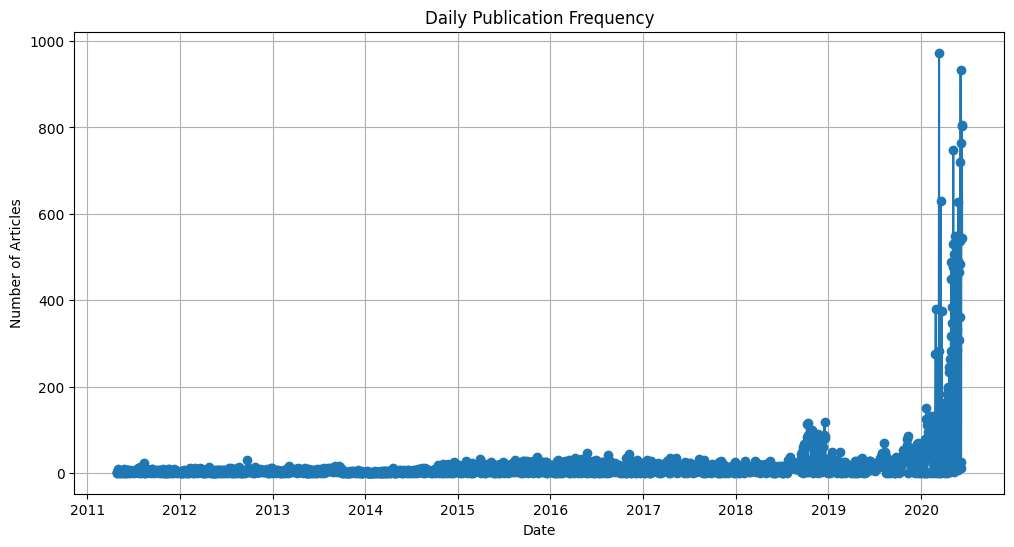

In [11]:
# Group by date and count the number of articles
daily_counts = data.groupby('date_only').size()

# Plot the publication frequency
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
daily_counts.plot(kind='line', marker='o', title='Daily Publication Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid()
plt.show()

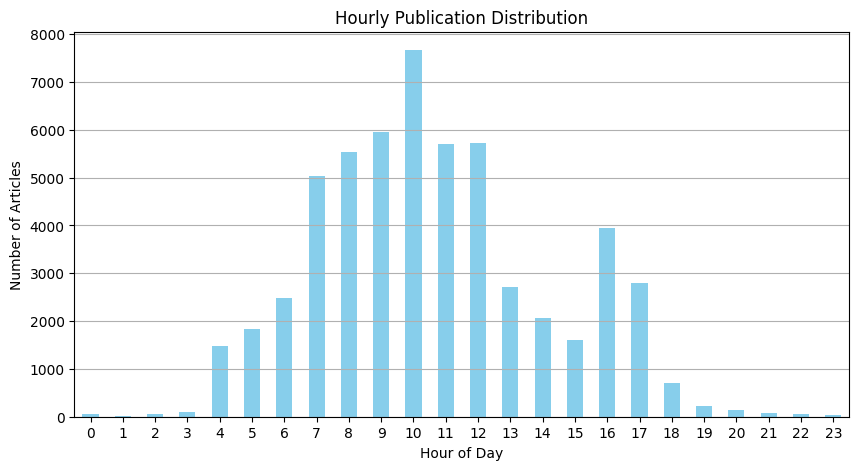

In [12]:
# Group by hour and count the number of articles
hourly_counts = data.groupby('hour').size()

# Plot the hourly distribution
plt.figure(figsize=(10, 5))
hourly_counts.plot(kind='bar', color='skyblue', title='Hourly Publication Distribution')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [13]:
# Sort by the highest publication days
spikes = daily_counts.sort_values(ascending=False).head(5)
print("Top days with most publications:\n", spikes)

# Filter data for one of the spike days
spike_day = data[data['date_only'] == spikes.index[0]]
print(spike_day[['headline', 'date', 'publisher']])

Top days with most publications:
 date_only
2020-03-12    973
2020-06-05    932
2020-06-10    806
2020-06-09    804
2020-06-08    765
dtype: int64
                                                  headline  \
5741              Stocks That Hit 52-Week Lows On Thursday   
9679              Stocks That Hit 52-Week Lows On Thursday   
10502             Stocks That Hit 52-Week Lows On Thursday   
13320             Stocks That Hit 52-Week Lows On Thursday   
14335             Stocks That Hit 52-Week Lows On Thursday   
...                                                    ...   
1389019  The Daily Biotech Pulse: AstraZeneca Faces Set...   
1389243  22ND Century Group Net Sales Revenue For Q4 In...   
1389873           Stocks That Hit 52-Week Lows On Thursday   
1399794           Stocks That Hit 52-Week Lows On Thursday   
1405506           Stocks That Hit 52-Week Lows On Thursday   

                             date          publisher  
5741    2020-03-12 12:10:12-04:00         Lisa Levin 

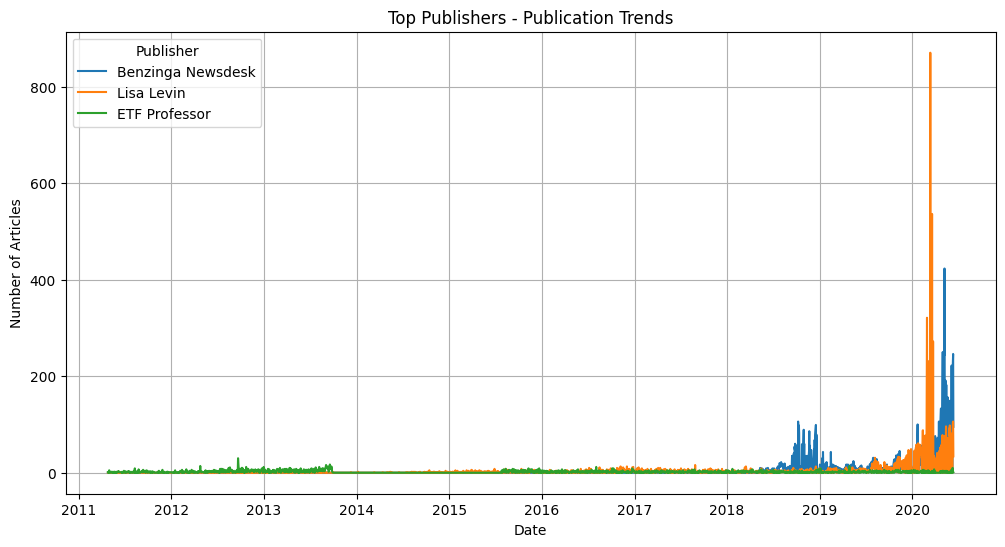

In [14]:
# Group by publisher and date to see trends
publisher_trends = data.groupby(['publisher', 'date_only']).size().unstack(fill_value=0)

# Plot trends for top publishers
top_publishers = data['publisher'].value_counts().head(3).index  # Top 3 publishers
publisher_trends.loc[top_publishers].T.plot(figsize=(12, 6), title='Top Publishers - Publication Trends')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid()
plt.legend(title='Publisher')
plt.show()

                            Publisher Analysis:


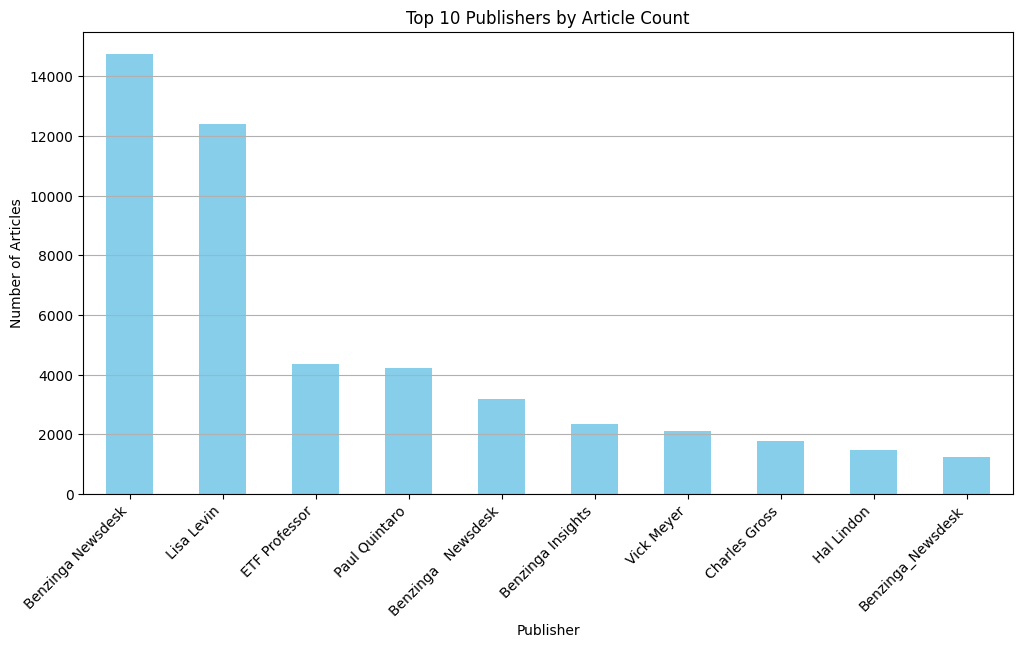

publisher
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Benzinga Insights     2332
Vick Meyer            2128
Charles Gross         1790
Hal Lindon            1470
Benzinga_Newsdesk     1239
Name: count, dtype: int64


In [15]:
 #Count the number of articles per publisher
publisher_counts = data['publisher'].value_counts()

# Plot the frequency of articles published by each publisher
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
publisher_counts.head(10).plot(kind='bar', color='skyblue', title='Top 10 Publishers by Article Count')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()


# Display the top publishers and their article counts
print(publisher_counts.head(10))

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# Define a function to extract common keywords for each publisher
def extract_keywords_by_publisher(publisher_name):
    publisher_data = data[data['publisher'] == publisher_name]
    vectorizer = CountVectorizer(stop_words='english', max_features=10)
    X = vectorizer.fit_transform(publisher_data['headline'])
    keywords = vectorizer.get_feature_names_out()
    return keywords

# Example: Extract keywords for the top 3 publishers
top_publishers = publisher_counts.head(3).index
for publisher in top_publishers:
    keywords = extract_keywords_by_publisher(publisher)
    print(f"Top 10 keywords for {publisher}:", keywords)

Top 10 keywords for Benzinga Newsdesk: ['52' 'eps' 'estimate' 'new' 'sales' 'shares' 'stocks' 'trading' 'week'
 'yoy']
Top 10 keywords for Lisa Levin: ['52' 'biggest' 'hit' 'lows' 'market' 'mid' 'movers' 'stocks' 'thursday'
 'week']
Top 10 keywords for ETF Professor: ['2013' 'bond' 'cap' 'dividend' 'etf' 'etfs' 'new' 'september' 'small'
 'watch']
